/tmp/ipykernel_2564926/1026040512.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_communities))


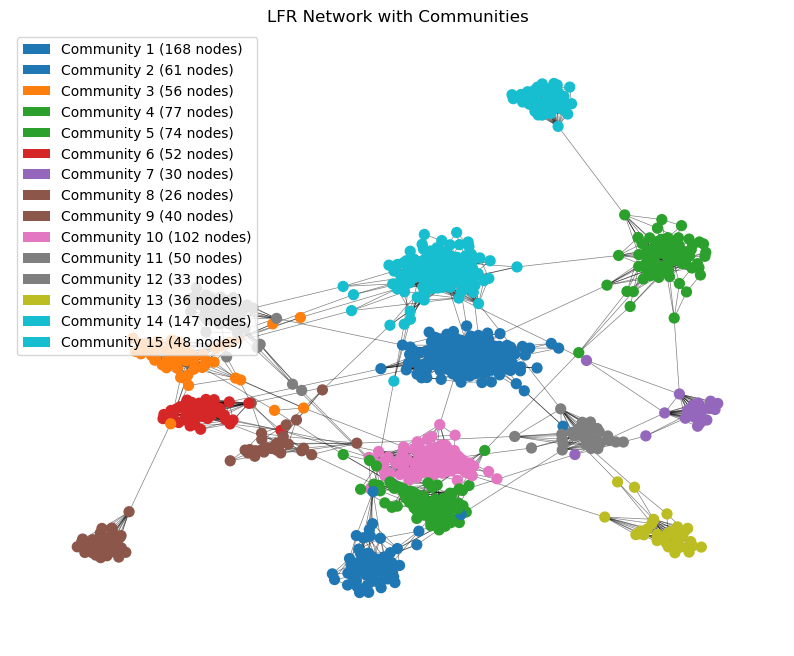

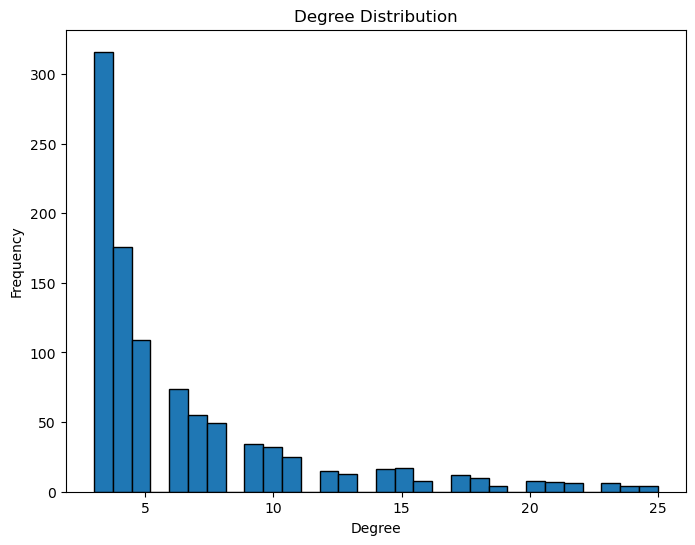

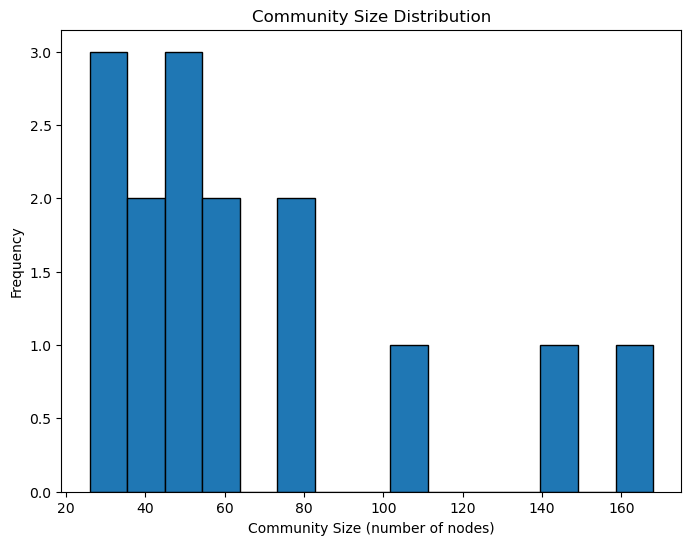

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import lfr  # Make sure this package is installed

# Set the random seed
#np.random.seed(42)

def create_network(params={
    "N": 1000,     # number of nodes
    "k": 6,        # average degree
    "maxk": 25,    # maximum degree
    "minc": 25,    # minimum community size
    "maxc": 250,   # maximum community size
    "tau": 2,      # degree exponent
    "tau2": 1.5,   # community size exponent
    "mu": 0.01,     # mixing rate
}):
    ng = lfr.NetworkGenerator()
    data = ng.generate(**params)
    net = data["net"]                  # scipy.csr_sparse matrix
    community_table = data["community_table"]  # pandas DataFrame
    seed = data["seed"]                # Seed value
    return net, community_table, seed

# Generate the network and the associated community table
A, community_labels, _ = create_network()

# Create a NetworkX graph from the sparse matrix
G = nx.from_scipy_sparse_array(A)

# --- Prepare community information and colors ---

# Assume that the DataFrame `community_labels` has columns "node_id" and "community_id".
# Create a mapping from each node to its community.
node_to_community = community_labels.set_index('node_id')['community_id'].to_dict()

# Get the sorted list of unique communities.
unique_communities = sorted(set(node_to_community.values()))

# Use a colormap (here, 'tab10') to generate a color for each community.
colors = plt.cm.get_cmap('tab10', len(unique_communities))
# Map each community to a specific color.
community_to_color = {community: colors(i) for i, community in enumerate(unique_communities)}

# Create a list of colors for each node based on its community.
node_colors = [community_to_color[node_to_community[node]] for node in G.nodes()]

# --- Plot the network graph with an updated legend ---

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Compute the layout for visualization

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5)

plt.axis('off')
plt.title('LFR Network with Communities')

# Count how many nodes are in each community.
community_counts = community_labels['community_id'].value_counts().to_dict()

# Create legend entries that include the community id and the number of nodes.
legend_elements = [
    Patch(facecolor=community_to_color[comm],
          label=f'Community {comm} ({community_counts[comm]} nodes)')
    for comm in unique_communities
]

plt.legend(handles=legend_elements, loc='best')
plt.show()

# --- Plot the Degree Distribution ---

# Compute degrees for all nodes in the graph.
degrees = [deg for node, deg in G.degree()]

plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=30, edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

# --- Plot the Community Size Distribution ---

# The community sizes are just the counts we computed above.
community_sizes = list(community_counts.values())

plt.figure(figsize=(8, 6))
plt.hist(community_sizes, bins=15, edgecolor='black')
plt.xlabel("Community Size (number of nodes)")
plt.ylabel("Frequency")
plt.title("Community Size Distribution")
plt.show()

In [2]:
nx.write_edgelist(G,"lfr_edgelist.txt")

# Just get the embeddings from the library here
import mercator
mercator.embed('lfr_edgelist.txt',screen_mode=True)



Mercator: accurate embeddings of graphs in the S1 space
version: 0.9
started on: 2025/02/19 11:51 UTC
edgelist filename: lfr_edgelist.txt
seed: 1739965893

Loading edgelist......................................................................done.

Checking number of connected components...............................................done.

Analyzing degrees.....................................................................done.

Computing local clustering............................................................done.

Ordering vertices.....................................................................done.

Properties of the graph
    Nb vertices:                    1000
    Nb edges:                       3254
    Average degree:                 6.508
    Minimum degree:                 3
    Maximum degree:                 25
    Nb of degree class:             23
    Average clustering:             0.2072

Inferring parameters...
           beta      avg. clustering 
        

Plotting the hyperbolic embedding gotten from mercator

In [3]:
import numpy as np

# Load inferred coordinates from your file
coord_inferred = 'lfr_edgelist.inf_coord'  # Adjust this path if necessary
data = np.loadtxt(coord_inferred, usecols=[0, 1, 2, 3], dtype={'names': ('name', 'kappa', 'theta', 'radius'), 'formats': ('i', 'f4', 'f4', 'f4')})


In [4]:
len(set(community_labels['community_id']))

15

/tmp/ipykernel_2564926/3462166041.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(sorted_communities))


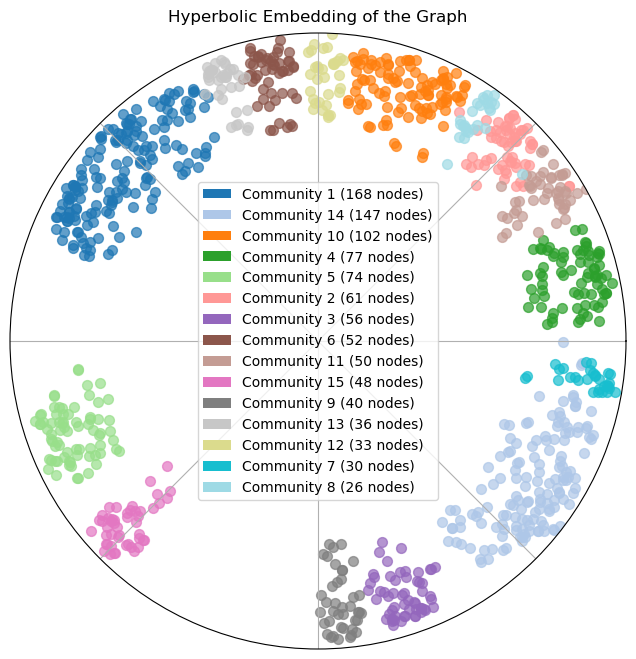

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

def plot_hyperbolic_disk(data, community_labels):
    # Extract theta and radius from the data
    theta = data['theta']
    radius = data['radius']
    
    # Create a mapping from node id to its community id
    node_to_community = dict(zip(community_labels['node_id'], community_labels['community_id']))
    
    # Count the number of nodes in each community
    community_sizes = community_labels['community_id'].value_counts().to_dict()

    # Sort communities by size (largest first)
    sorted_communities = sorted(community_sizes, key=lambda x: -community_sizes[x])
    
    # Use a colormap with enough distinct colors
    cmap = plt.cm.get_cmap('tab20', len(sorted_communities))
    
    # Create a polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

    # Plot each community in descending order of size
    for i, comm in enumerate(sorted_communities):
        # Get nodes in this community
        community_nodes = community_labels[community_labels['community_id'] == comm]['node_id']
        
        # Get their corresponding theta and radius
        comm_theta = [theta[node] for node in community_nodes]
        comm_radius = [radius[node] for node in community_nodes]
        
        # Plot nodes in this community
        ax.scatter(comm_theta, comm_radius, color=cmap(i), alpha=0.7, s=50, label=f'Community {comm} ({community_sizes[comm]} nodes)')

    # Customize the plot (remove radial labels, angular ticks, etc.)
    ax.set_rticks([])  # Remove radial ticks
    ax.set_xticklabels([])  # Remove angular tick labels
    ax.set_ylim(0, np.max(radius))  # Set radial axis limits
    
    # Add a title
    ax.set_title("Hyperbolic Embedding of the Graph", va='bottom')
    
    # Create legend elements for each community
    legend_elements = [
        Patch(facecolor=cmap(i), label=f'Community {comm} ({community_sizes[comm]} nodes)')
        for i, comm in enumerate(sorted_communities)
    ]
    ax.legend(handles=legend_elements, loc='best')

    # Show the plot
    plt.show()

# Example usage:
# Assuming 'data' is a dictionary containing 'theta' and 'radius' arrays,
# and 'community_labels' is a pandas DataFrame with 'node_id' and 'community_id'
plot_hyperbolic_disk(data, community_labels)

/tmp/ipykernel_2564926/2832194235.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_communities))


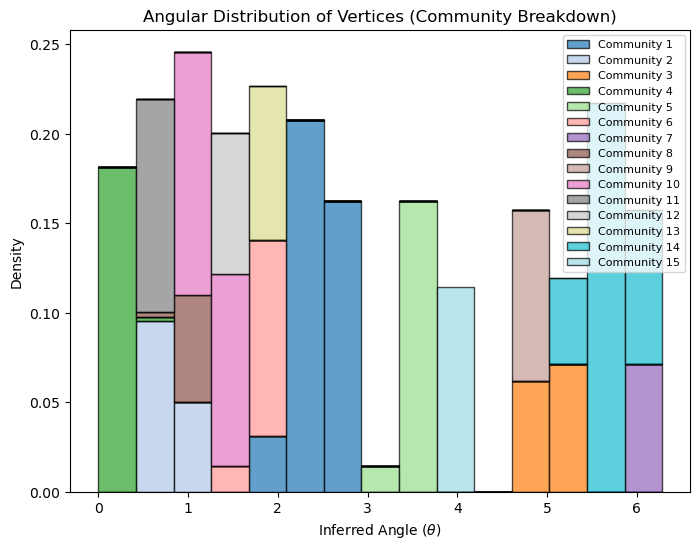

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_theta_distribution(data, community_labels):
    # Extract theta values
    theta = data['theta']
    
    # Get unique communities and their corresponding colors
    unique_communities = sorted(community_labels['community_id'].unique())
    cmap = plt.cm.get_cmap('tab20', len(unique_communities))
    
    # Group theta values by community
    theta_by_community = {comm: [] for comm in unique_communities}
    
    for node, comm in zip(community_labels['node_id'], community_labels['community_id']):
        theta_by_community[comm].append(theta[node])
    
    # Prepare data for stacked histogram
    theta_values = [theta_by_community[comm] for comm in unique_communities]
    
    # Create a histogram (stacked)
    plt.figure(figsize=(8, 6))
    bins = np.linspace(0, np.pi * 2, len(unique_communities)+1)  # Divide 0 to 2π into 20 bins
    plt.hist(theta_values, bins=bins, density=True, stacked=True,
             label=[f'Community {comm}' for comm in unique_communities], 
             color=[cmap(i) for i in range(len(unique_communities))], edgecolor='k', alpha=0.7)
    
    # Customize plot
    plt.xlabel(r"Inferred Angle $(\theta)$")
    plt.ylabel("Density")
    plt.title("Angular Distribution of Vertices (Community Breakdown)")
    
    # Add legend
    plt.legend(loc='upper right', fontsize=8)
    
    # Show the plot
    plt.show()

# Call the function to plot the angular distribution with community breakdown
plot_theta_distribution(data, community_labels)


#### Great, now we plot the embeddings gotten from node2vec for this network

In [7]:
import embcom
emb_params = {
                "method": "node2vec",
                "window_length": 10,
                "walk_length": 80,
                "num_walks": 10,
                "dim" : 64,
                }
model = embcom.embeddings.Node2Vec(window_length = emb_params['window_length'],
                           walk_length=emb_params['walk_length'],
                           num_walks=emb_params['num_walks'])
#model = embcom.embeddings.LaplacianEigenMap()
model.fit(G)
emb = model.transform(dim=emb_params['dim'])


Ignore this message if you do not use Glove. Otherwise, install glove python package by 'pip install glove_python_binary' 


In [8]:
np.shape(emb)

(1000, 64)

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_1581173/779022159.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(sorted_communities))


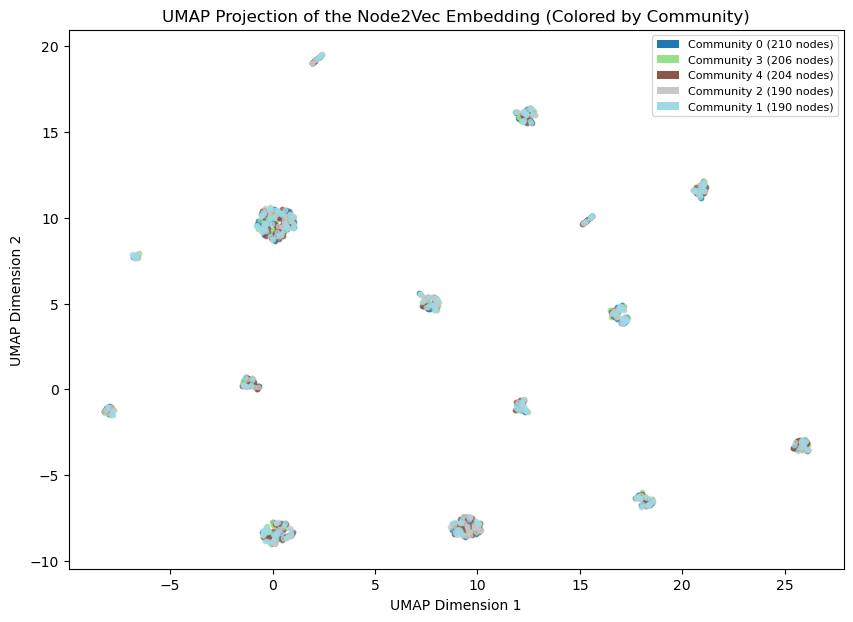

In [149]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

def plot_umap_with_communities(embedding, community_labels):
    # Step 1: Apply UMAP to reduce the dimensionality to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(embedding)

    # Step 2: Count nodes in each community and sort by size (largest first)
    community_sizes = community_labels['community_id'].value_counts().to_dict()
    sorted_communities = sorted(community_sizes, key=lambda x: -community_sizes[x])

    # Step 3: Assign colors using `tab20` colormap
    cmap = plt.cm.get_cmap('tab20', len(sorted_communities))
    community_to_color = {comm: cmap(i) for i, comm in enumerate(sorted_communities)}

    # Step 4: Create a figure
    plt.figure(figsize=(10, 7))

    # Step 5: Plot each community in order (largest first)
    for comm in sorted_communities:
        # Extract nodes belonging to this community
        community_nodes = community_labels[community_labels['community_id'] == comm].index

        # Get their UMAP coordinates
        plt.scatter(embedding_2d[community_nodes, 0], embedding_2d[community_nodes, 1],
                    color=community_to_color[comm], s=10, alpha=0.7, label=f'Community {comm} ({community_sizes[comm]} nodes)')

    # Step 6: Customize the plot
    plt.title('UMAP Projection of the Node2Vec Embedding (Colored by Community)')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # Step 7: Create a legend with community size
    legend_elements = [
        Patch(facecolor=community_to_color[comm], label=f'Community {comm} ({community_sizes[comm]} nodes)')
        for comm in sorted_communities
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=8)

    # Step 8: Show the plot
    plt.show()

# Call the function to plot the UMAP visualization with community-based colors
plot_umap_with_communities(emb, community_labels)


We can see that they are well separated. Let's look at the pairwise angular distance matrix for the coordinates in the hyperbolic and node2vec embedding spaces, and see how similar they are

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity_node2vec_pre = cosine_similarity(emb)

In [58]:
# Step 2: Calculate cosine similarity for hyperbolic embedding using theta
theta = data['theta']
n = len(theta)

# Create an empty matrix for the cosine similarity
cosine_similarity_hyperbolic = np.zeros((n, n))

# Fill the cosine similarity matrix
for i in range(n):
    for j in range(n):
        cosine_similarity_hyperbolic[i, j] = np.cos(theta[i] - theta[j])

# Output the cosine similarity matrices
print("Cosine Similarity Matrix for Node2Vec Embedding:")
print(cosine_similarity_node2vec_pre)

print("\nCosine Similarity Matrix for Hyperbolic Embedding:")
print(cosine_similarity_hyperbolic)

Cosine Similarity Matrix for Node2Vec Embedding:
[[1.         0.37919931 0.38931452 ... 0.33854899 0.42014461 0.28380277]
 [0.37919931 1.         0.83716366 ... 0.38703834 0.37496081 0.24359481]
 [0.38931452 0.83716366 1.         ... 0.43894165 0.40505283 0.22300286]
 ...
 [0.33854899 0.38703834 0.43894165 ... 1.         0.41559851 0.26507086]
 [0.42014461 0.37496081 0.40505283 ... 0.41559851 1.         0.36757554]
 [0.28380277 0.24359481 0.22300286 ... 0.26507086 0.36757554 1.        ]]

Cosine Similarity Matrix for Hyperbolic Embedding:
[[ 1.         -0.92454261 -0.88251507 ... -0.97142887 -0.55462778
  -0.0700464 ]
 [-0.92454261  1.          0.99513805 ...  0.80768567  0.19568199
   0.44490355]
 [-0.88251507  0.99513805  1.         ...  0.74568772  0.09814461
   0.53094602]
 ...
 [-0.97142887  0.80768567  0.74568772 ...  1.          0.73626405
  -0.16870274]
 [-0.55462778  0.19568199  0.09814461 ...  0.73626405  1.
  -0.79120505]
 [-0.0700464   0.44490355  0.53094602 ... -0.16870274

In [65]:
# However the range of cosine similarities are -1,1 and 0,1.
print(np.min(cosine_similarity_node2vec_pre),np.min(cosine_similarity_hyperbolic))

# Inorder to correct it, we do a linear transform:
import numpy as np
from scipy.stats import pearsonr

# Assume we have two lists of similarity values:
# - hyperbolic_sim: cosine similarities from hyperbolic embeddings (range: [-1, 1])
# - node2vec_sim: cosine similarities from Node2Vec (range: [0, 1])


# Step 1: Transform Node2Vec similarities to [-1,1]
cosine_similarity_node2vec = 2 * cosine_similarity_node2vec_pre - 1
print(np.min(cosine_similarity_node2vec),np.min(cosine_similarity_hyperbolic))

# # Step 2: Compute Pearson correlation
# correlation, p_value = pearsonr(cosine_similarity_node2vec, cosine_similarity_hyperbolic)

# print(f"Pearson Correlation: {correlation:.4f}, p-value: {p_value:.4f}")

0.0233214432247616 -1.0
-0.9533571135504768 -1.0


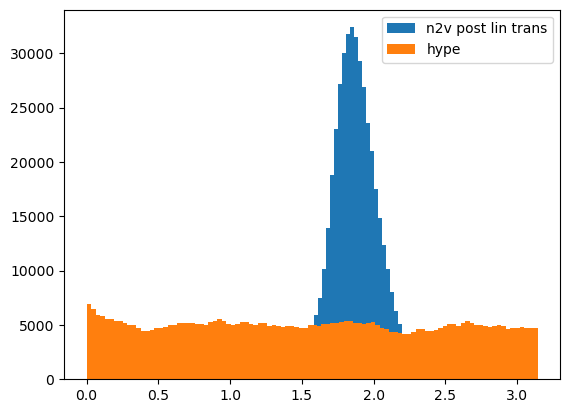

In [152]:
#plt.hist(cosine_similarity_node2vec_pre[np.triu_indices(1000, k = 1)],bins=100,label='pre trans n2v')
plt.hist(np.arccos(cosine_similarity_node2vec[np.triu_indices(1000, k = 1)]), bins=100,label='n2v post lin trans')
plt.hist(np.arccos(cosine_similarity_hyperbolic[np.triu_indices(1000, k = 1)]), bins=100, label='hype')
plt.legend()


In [17]:
data.dtype.names, data

(('name', 'kappa', 'theta', 'radius'),
 array([(  0,  1.91854, 2.27971  , 16.5198),
        (  1,  4.25451, 4.71866  , 14.927 ),
        (  2,  1.79482, 5.60833  , 16.6532),
        (  3,  2.47806, 0.218548 , 16.008 ),
        (  4,  1.98202, 0.796115 , 16.4547),
        (  5,  2.22072, 3.94687  , 16.2273),
        (  6,  3.11334, 5.9754   , 15.5516),
        (  7,  2.78354, 0.259579 , 15.7755),
        (  8,  2.77424, 5.08175  , 15.7822),
        (  9,  2.54004, 2.69947  , 15.9586),
        ( 10,  2.89884, 6.10184  , 15.6943),
        ( 11,  2.10069, 2.44898  , 16.3384),
        ( 12,  3.06734, 2.48846  , 15.5814),
        ( 13,  2.46859, 4.82998  , 16.0157),
        ( 14,  2.802  , 0.255739 , 15.7623),
        ( 15,  2.95326, 0.883792 , 15.6571),
        ( 16,  2.4427 , 1.6714   , 16.0368),
        ( 17,  1.9406 , 2.384    , 16.497 ),
        ( 18,  2.98825, 2.58208  , 15.6336),
        ( 19,  2.97225, 3.52052  , 15.6443),
        ( 20,  3.34064, 3.44131  , 15.4106),
        ( 21,  2

In [19]:
import numpy as np
from scipy.stats import pearsonr, spearmanr


from scipy.spatial import procrustes

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def center_embeddings(V):
    # Subtract the mean of each column from the corresponding entries
    term  = V - np.mean(V, axis=0)
    #return term
    return term/ np.linalg.norm(term)

def calculate_normalized_embedding_loss(V_a, V_b):
    # Step 1: Center both embedding matrices
    V_a_centered = center_embeddings(V_a)
    V_b_centered = center_embeddings(V_b)
    
    # Step 2: Calculate cosine similarity matrices for centered embeddings
    C_a = cosine_similarity(V_a_centered)
    C_b = cosine_similarity(V_b_centered)
    
    # Step 3: Calculate the absolute differences between cosine similarities
    N = V_a.shape[0]
    loss = 0
    
    # Only sum over the upper triangular part of the matrix (i < j)
    for i in range(N):
        for j in range(i+1, N):
            loss += np.abs(C_a[i, j] - C_b[i, j])
    
    # Step 4: Normalize the loss
    normalized_loss = (2 / (N * (N - 1))) * loss
    
    return normalized_loss
    

In [ ]:
# Example usage:
theta = data['theta']  # Converting theta into x,y coordinates on disk of radius 1

Vh = np.column_stack((np.cos(theta), np.sin(theta))) # This is already centred, so we don't have to worry
Vn = center_embeddings(emb)

loss = calculate_normalized_embedding_loss(Vh, Vn)



# Assume embedding_1 and embedding_2 are the original embeddings, not the cosine matrices
mtx1, mtx2, disparity = procrustes(cosine_similarity_node2vec, cosine_similarity_hyperbolic)

# Step 1: Flatten the upper triangular part of both matrices (since they are symmetric)
indices = np.triu_indices_from(cosine_similarity_node2vec, k=1)
matrix_1_flat = cosine_similarity_node2vec[indices]
matrix_2_flat = cosine_similarity_hyperbolic[indices]

# Step 2: Compute Pearson correlation between the two flattened matrices
pearson_corr, _ = pearsonr(matrix_1_flat, matrix_2_flat)

# Compute Spearman correlation as well (optional)
spearman_corr, _ = spearmanr(matrix_1_flat, matrix_2_flat)
frobenius_norm = np.linalg.norm(cosine_similarity_node2vec - cosine_similarity_hyperbolic, ord='fro')
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

print(f"Procrustes Disparity: {disparity}") # smaller is better aligned
print(f"Normalized Embedding Loss: {loss}")

Pearson Correlation: 0.4739049507935453
Spearman Correlation: 0.41457976977996447
Procrustes Disparity: 0.7096659585283295
Normalized Embedding Loss: 0.5415879178823049


Pearson Correlation: 0.4739049507935452
Spearman Correlation: 0.41457976977996447
Procrustes Disparity: 0.7096659585283294
Normalized Embedding Loss: 0.5415879178823049


In [1]:
# Correlation for length

In [78]:
hype_dists = data['radius']
n2v_dists  = np.linalg.norm(emb,axis=1)

In [79]:
pearson_corr, _ = pearsonr(hype_dists, n2v_dists)
spearman_corr, _ = spearmanr(hype_dists, n2v_dists)
print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

Pearson Correlation: 0.12671805293594426
Spearman Correlation: 0.1006973192286987


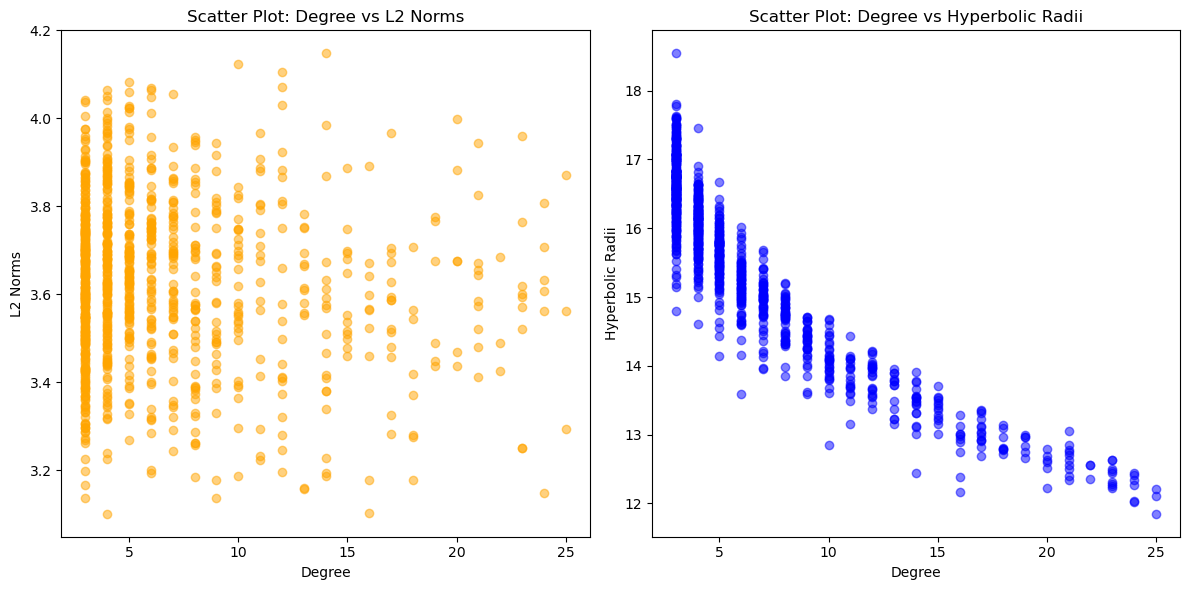

In [80]:
degrees = [i[1] for i in (nx.degree(G))]

# Generate some example degree data for the scatter plot (replace with actual data)
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for degrees vs n2v_dists
ax1.scatter(degrees, n2v_dists, alpha=0.5, color='orange')
ax1.set_xlabel('Degree')
ax1.set_ylabel('L2 Norms')
ax1.set_title('Scatter Plot: Degree vs L2 Norms')

# Scatter plot for degrees vs hype_dists
#ax2.set_yscale("log")
ax2.scatter(degrees, hype_dists, alpha=0.5, color='blue')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Hyperbolic Radii')
ax2.set_title('Scatter Plot: Degree vs Hyperbolic Radii')

# Display the plot
plt.tight_layout()
plt.show()


## Angular Synchronization

In [22]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import math

def angular_synchronization(n, measurements):
    """
    Compute the angles on S^1 via angular synchronization.
    
    Parameters:
    - n: int, number of nodes.
    - measurements: list of tuples (i, j, delta_theta) indicating that
      measurement from node i to node j is delta_theta (in radians).
      
    Returns:
    - theta_est: numpy array of estimated angles for each node.
    """
    # Build lists for sparse matrix construction
    row = []
    col = []
    data = []
    
    # For each measurement, add H_{ij} = exp(i * delta_theta)
    for i, j, delta in measurements:
        row.append(i)
        col.append(j)
        data.append(np.exp(1j * delta))
        
        # Optionally, if the measurements are symmetric, you can add the conjugate
        # measurement as well:
        row.append(j)
        col.append(i)
        data.append(np.exp(-1j * delta))
    
    # Construct sparse matrix H
    H = coo_matrix((data, (row, col)), shape=(n, n)).tocsr()
    
    # Compute the leading eigenvector
    # Note: since H is generally non-Hermitian if measurements are inconsistent,
    # we may want to compute eigenvalues of H (or H + H^*.T for symmetry).
    # Here, we assume H is approximately Hermitian.
    vals, vecs = eigs(H, k=1, which='LM')
    v = vecs[:, 0]
    
    # Normalize the eigenvector (not strictly necessary)
    v = v / np.abs(v)
    
    # Extract angles
    theta_est = np.angle(v)
    
    return theta_est

import numpy as np

def align_angles(theta_true, theta_est):
    """
    Align estimated angles to the true angles by finding the optimal global offset.
    
    Parameters:
      theta_true : numpy.ndarray
          The ground truth angles (in radians).
      theta_est : numpy.ndarray
          The estimated angles (in radians).
    
    Returns:
      theta_est_aligned : numpy.ndarray
          The estimated angles shifted by the optimal offset.
      offset : float
          The computed optimal offset.
    """
    # Compute the differences between true and estimated angles.
    # Because the angles are periodic, we compute these differences in the complex plane.
    differences = np.exp(1j * (theta_true - theta_est))
    
    # The optimal global offset is the phase (angle) of the mean of these differences.
    offset = np.angle(np.mean(differences))
    
    # Align the estimated angles by adding the offset and wrapping them into [0, 2*pi)
    theta_est_aligned = (theta_est + offset) % (2 * np.pi)
    return theta_est_aligned, offset



n_nodes = len(G.nodes())
np.random.seed(42)

true_angles = np.array([datum['theta'] for datum in data] )
cosine_similarity_node2vec = cosine_similarity((emb))

measurements = []

for i in range(n_nodes):
    for j in range(i+1, n_nodes):
               
        measurements.append((i, j, math.acos(cosine_similarity_node2vec[i][j])))


# Run angular synchronization
theta_est = angular_synchronization(n_nodes, measurements)
#print("Estimated angles:", theta_est)

theta_aligned, offset = align_angles(true_angles, theta_est)
print("Optimal offset:", offset)
#print("Aligned estimated angles:", theta_aligned)

Optimal offset: -0.816873130574169


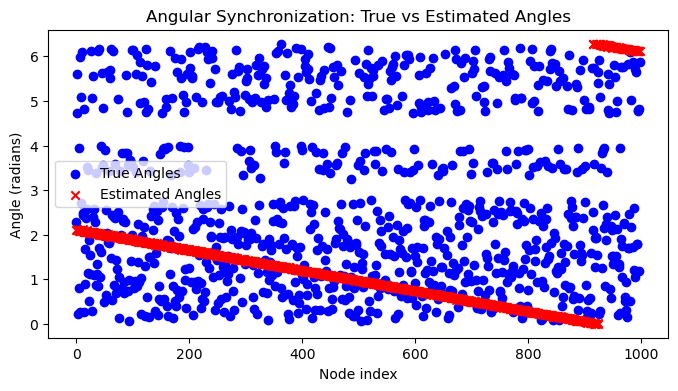

In [26]:
n_printb = 0
n_printe = 999
plt.figure(figsize=(8,4))
plt.scatter(range(n_printb,n_printe), true_angles[n_printb:n_printe], c='blue', label='True Angles')
plt.scatter(range(n_printb,n_printe), theta_aligned[n_printb:n_printe], c='red', marker='x', label='Estimated Angles')
plt.xlabel('Node index')
plt.ylabel('Angle (radians)')
plt.legend()
plt.title('Angular Synchronization: True vs Estimated Angles')
plt.show()

Optimal offset: 2.3163870435131155


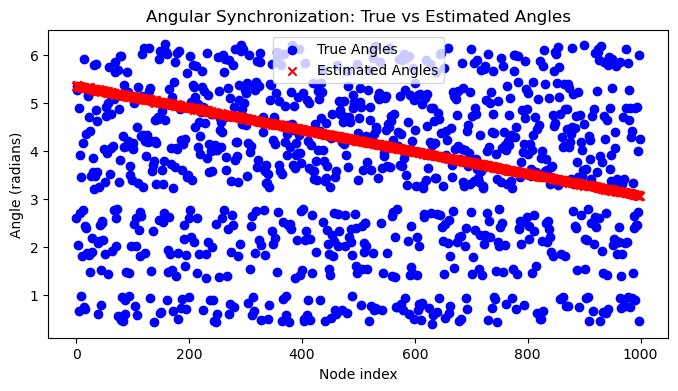

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs

# -----------------------------
# Angular Synchronization Code
# -----------------------------
def angular_synchronization(n, measurements):
    """
    Compute the angles on S^1 via angular synchronization.

    Parameters:
      n: int, number of nodes.
      measurements: list of tuples (i, j, delta_theta) indicating that
        the measurement from node i to node j is delta_theta (in radians).

    Returns:
      theta_est: numpy array of estimated angles for each node.
    """
    # Build lists for sparse matrix construction
    row = []
    col = []
    data = []
    
    # For each measurement, add H_{ij} = exp(i * delta_theta)
    for i, j, delta in measurements:
        row.append(i)
        col.append(j)
        data.append(np.exp(1j * delta))
        
        # Also add the conjugate measurement to enforce antisymmetry:
        row.append(j)
        col.append(i)
        data.append(np.exp(-1j * delta))
    
    # Construct sparse matrix H
    H = coo_matrix((data, (row, col)), shape=(n, n)).tocsr()
    
    # Compute the leading eigenvector.
    # (We assume H is approximately Hermitian.)
    vals, vecs = eigs(H, k=1, which='LM')
    v = vecs[:, 0]
    
    # Normalize the eigenvector (each entry divided by its magnitude)
    v = v / np.abs(v)
    
    # Extract angles from the complex phases
    theta_est = np.angle(v)
    
    return theta_est

def align_angles(theta_true, theta_est):
    """
    Align estimated angles to the true angles by finding the optimal global offset.
    
    Parameters:
      theta_true : numpy.ndarray
          The ground truth angles (in radians).
      theta_est : numpy.ndarray
          The estimated angles (in radians).
    
    Returns:
      theta_est_aligned : numpy.ndarray
          The estimated angles shifted by the optimal offset.
      offset : float
          The computed optimal offset.
    """
    # Compute the differences in the complex plane
    differences = np.exp(1j * (theta_true - theta_est))
    
    # The optimal global offset is the phase of the mean difference
    offset = np.angle(np.mean(differences))
    
    # Apply the offset (and wrap into [0, 2*pi))
    theta_est_aligned = (theta_est + offset) % (2 * np.pi)
    return theta_est_aligned, offset


n = len(G.nodes())

#cosine_matrix = cosine_similarity_node2vec
true_angles = data['theta']

cosine_matrix = cosine_similarity(emb - np.mean(emb, axis=0))
#cosine_matrix = cosine_similarity(emb )
measurements = []
for i in range(n):
    for j in range(i+1, n):
        # Compute the unsigned angle difference
        cos = (cosine_matrix[i, j])
        #delta = np.arctan2(np.sqrt(1- cos**2),cos)
        delta = math.acos(cos)
        measurements.append((i, j, delta))

# measurements = []
# for i in range(n):
#     for j in range(i+1,n):
#         delta = np.pi - np.abs(np.pi - np.abs(data['theta'][i] - data['theta'][j])) #+  np.random.normal(0, 0.1)
#         measurements.append((i,j,delta))
        
# Run angular synchronization
theta_est = angular_synchronization(n_nodes, measurements)
#print("Estimated angles:", theta_est)

theta_aligned, offset = align_angles(true_angles, theta_est)
print("Optimal offset:", offset)
#print("Aligned estimated angles:", theta_aligned)
 
plt.figure(figsize=(8,4))
plt.scatter(range(n_nodes), true_angles, c='blue', label='True Angles')
plt.scatter(range(n_nodes), theta_aligned, c='red', marker='x', label='Estimated Angles')
plt.xlabel('Node index')
plt.ylabel('Angle (radians)')
plt.legend()
plt.title('Angular Synchronization: True vs Estimated Angles')
plt.show()

In [148]:
emb

array([[-0.17911623, -0.81152534, -0.34416151, ..., -0.61777848,
         0.46045303, -0.41266778],
       [-0.4938007 , -0.70790505, -0.35416001, ..., -0.1092367 ,
         0.27545574,  0.0323911 ],
       [-0.28154674, -0.31251869, -0.23196973, ..., -0.42933348,
         0.67248881,  0.24205381],
       ...,
       [ 0.35051724, -0.14384349, -0.41458556, ...,  0.22159541,
        -0.29582867,  0.79941386],
       [-0.02076532, -0.51965487, -0.61322242, ..., -0.09937095,
        -0.36581871, -0.5636735 ],
       [-0.28773028, -0.36978519, -0.4054755 , ..., -0.49310684,
        -0.19824815, -0.08708794]])